# Sparse Target Dataset Hyperparameters Tunning
The objective of this notebook is to tune the hyperparameters of the model to obtain the best performance on the sparse dataset. 

**Summary of the Article**
- Description of the dataset.
- Hyperparameters tunning:
    - Gradient Boosting Regressor.
    - SVRegressor.
    - Multi-Layer Perceptron.
    - Long-Short Term Memory.
- Training Models.
- Next Steps.

## Description of the Sparse Dataset 
The objective of this master thesis is to forecast the occurance and amplitude of constraints in the electrical grid. Using historical values of active and reactive power it is possible to compute the voltage and current values in the network, thus obtaining the occurance and amplitude of constraints. Since not every timestep containts a constraint, not every time step is woth to be predicted, so it is usefull transform the target features into a sequece of values that better represent the constraints. One way to obtain this target dataset is to set all time steps that do not characterise a constraint to 0, a positive value (with the amplitude of the constraint) otherwise. The following formula states the transformation:
$$
    \begin{align}
        \text{Target} &= \begin{cases}
            0 & \text{if} \; \text{constraint} \; \text{is not violated} \\
            \text{amplitude of constraint} & \text{if} \; \text{constraint} \; \text{is violated} \\
        \end{cases}
    \end{align}
$$

The resulting dataset is a sparse dataset, since constraints are not as common as regular values. Bellow the dataset for maximum voltage constraints is shown.

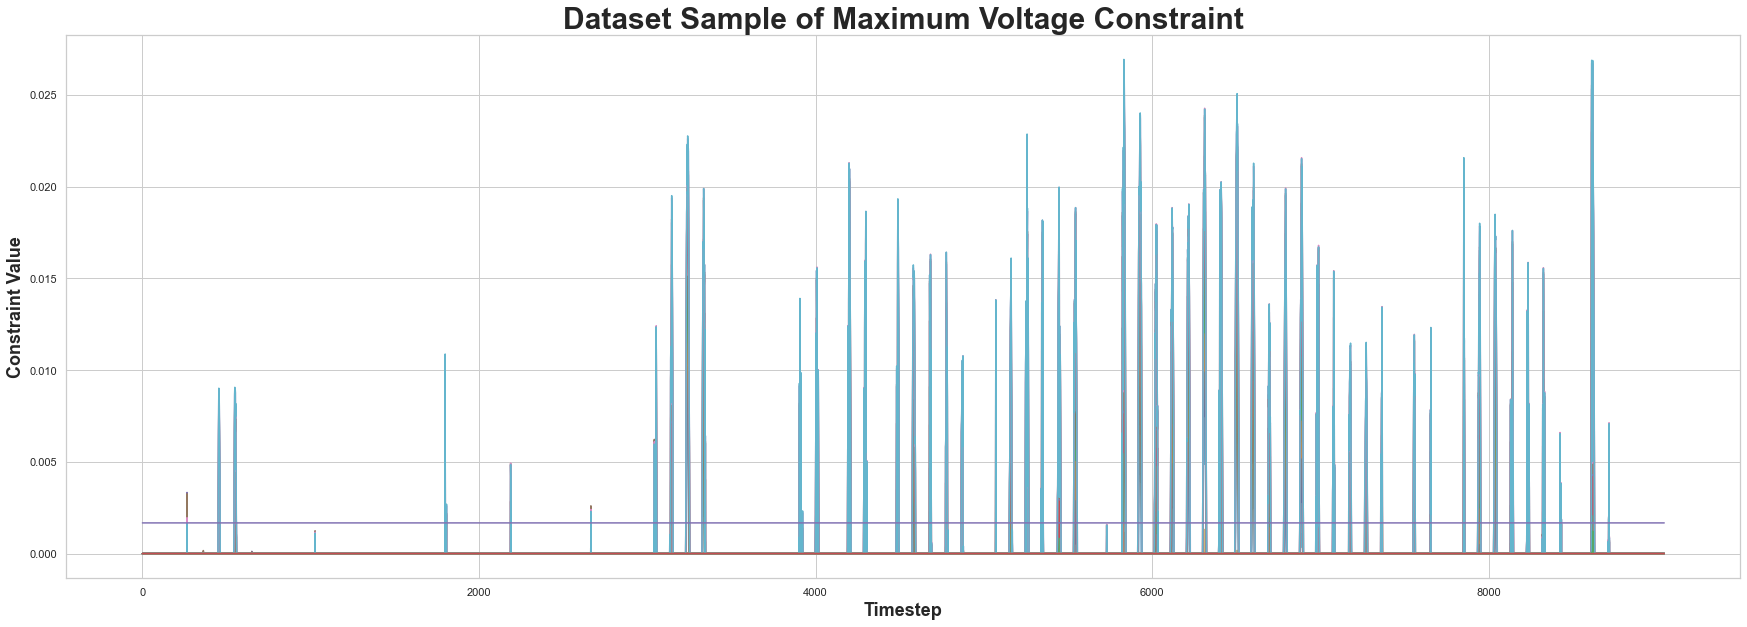

In [1]:
import sys; 
sys.path.append('..')
from thesis_package import utils

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

y_max_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_constr.csv').drop(columns='timestamps')
exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
X_max_u_train, X_max_u_test, y_max_u_train, y_max_u_test = utils.split_and_suffle(exogenous_data, y_max_u)
data = {'X_train': X_max_u_train, 'X_test': X_max_u_test, 'y_train': y_max_u_train, 'y_test': y_max_u_test}
threshold_value = y_max_u_train.loc[:, y_max_u_train.max(axis=0) != 0].max(axis=0).mean() * 0.1 
threshold_signal = pd.Series(np.ones([len(y_max_u_test)]) * threshold_value)
# Plot prediction_gb_max_u
sns.set(style='whitegrid')
fig, axs = plt.subplots(1, 1, figsize=(30, 10))
axs.plot(y_max_u_test.reset_index(drop=True))
axs.plot(threshold_signal)
axs.set_title('Dataset Sample of Maximum Voltage Constraint', fontsize=30, fontweight='bold')
axs.set_xlabel('Timestep', fontsize=18, fontweight='bold')
axs.set_ylabel('Constraint Value', fontsize=18, fontweight='bold')
plt.show()

## Import Libraries

In [9]:
import optuna 
import os

import numpy as np
import pandas as pd 
import sklearn.metrics
from sklearn.model_selection import train_test_split

import sys
sys.path.append('..')
from thesis_package import aimodels as my_ai, utils

## Hyperparameters Tunning of Models
The objective of this section is to tune the hyperparameters of the models to obtain the best performance on the sparse dataset. In order to perfom the hyperparameters tunning, we are going to use the optuna library presented in the `optuna_introduction.ipynb` notebook. The models are the ones implemented in the `aimodel.py` file in the `thesis_package`.

In [3]:
# General parameters
num_trials = 1

### Extreme Gradient Boosting Regressor

In [4]:
def objective(trial):
    # import data
    y_min_u = pd.read_csv('..\data\ground_truth\\res_line_percent_max_bool_constr.csv').drop(columns=['timestamps'])
    exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y = utils.split_and_suffle(exogenous_data, y_min_u)
    data = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}
    param = {
        "verbosity": 0,
        "objective": "binary:logistic",
        # use exact for small dataset.
        "tree_method": "exact",
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    model = my_ai.Context(my_ai.XGBoostRegressorStrategy(param))
    model.fit(data)
    prediction = model.predict(data)
    # evaluate the regression performance
    rmse = sklearn.metrics.mean_squared_error(valid_y, prediction, squared=False) # TODO add hybrid_metric here
    return rmse

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results/params_xgboost_regression_sparse.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))

[I 2022-08-13 13:00:47,286] A new study created in memory with name: no-name-b0185ebc-684d-4860-b9aa-470021503f79
[I 2022-08-13 13:01:08,231] Trial 0 finished with value: 6.464553967104657e-18 and parameters: {'booster': 'gblinear', 'lambda': 1.045976975399194e-06, 'alpha': 1.1142648940159587e-06, 'subsample': 0.6428471331031815, 'colsample_bytree': 0.3945019456782822}. Best is trial 0 with value: 6.464553967104657e-18.


Number of finished trials:  1
Best trial:
  Value: 6.464553967104657e-18
  Params: 
    booster: gblinear
    lambda: 1.045976975399194e-06
    alpha: 1.1142648940159587e-06
    subsample: 0.6428471331031815
    colsample_bytree: 0.3945019456782822


### Gradient Boosting Regressor

In [5]:
# Same implementation as above, but for Gradient Boosting Regression.
def objective(trial):
    # import data
    y_min_u = pd.read_csv('..\data\ground_truth\\res_line_percent_max_bool_constr.csv').drop(columns=['timestamps'])
    exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y = utils.split_and_suffle(exogenous_data, y_min_u)
    data = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 10000, log=True),
        'learning_rate': trial.suggest_float('learning_rate', 0.1, 1.0, log=True) ,
        'loss': trial.suggest_categorical('loss', ['squared_error', 'absolute_error', 'huber', 'quantile'])
    }
    model = my_ai.Context(my_ai.GradientBoostRegressorStrategy(param))
    model.fit(data)
    prediction = model.predict(data)
    # evaluate the regression performance
    rmse = sklearn.metrics.mean_squared_error(valid_y, prediction, squared=False)
    return rmse
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results/params_gradient_boost_regression_sparse.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))

[I 2022-08-13 13:01:08,426] A new study created in memory with name: no-name-fc224778-04c5-4167-9fcd-24d39f591cac
[I 2022-08-13 13:07:32,692] Trial 0 finished with value: 0.0 and parameters: {'n_estimators': 1777, 'learning_rate': 0.7499437544994538, 'loss': 'huber'}. Best is trial 0 with value: 0.0.


Number of finished trials:  1
Best trial:
  Value: 0.0
  Params: 
    n_estimators: 1777
    learning_rate: 0.7499437544994538
    loss: huber


### Support Vector Regressor

In [6]:
# Same implementation as above, but for Support Vector Regression.
def objective(trial):
    # import data
    y_min_u = pd.read_csv('..\data\ground_truth\\res_line_percent_max_bool_constr.csv').drop(columns=['timestamps'])
    exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y = utils.split_and_suffle(exogenous_data, y_min_u)
    data = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}
    param = {
        'kernel': trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid']),
        'C': trial.suggest_float('C', 1e-8, 1.0, log=True),
        'degree': trial.suggest_int('degree', 1, 5),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True)
    }
    model = my_ai.Context(my_ai.SupportVectorRegressorStrategy(param))
    model.fit(data)
    prediction = model.predict(data)
    # evaluate the regression performance
    rmse = sklearn.metrics.mean_squared_error(valid_y, prediction, squared=False)
    return rmse
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results/params_support_vector_regression_sparse.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))

[I 2022-08-13 13:07:32,817] A new study created in memory with name: no-name-b1323749-1061-414e-abe2-d308e58a66c3
[I 2022-08-13 13:07:33,926] Trial 0 finished with value: 0.0 and parameters: {'kernel': 'sigmoid', 'C': 6.781825120916302e-05, 'degree': 1, 'gamma': 0.0037356189491467256}. Best is trial 0 with value: 0.0.


Number of finished trials:  1
Best trial:
  Value: 0.0
  Params: 
    kernel: sigmoid
    C: 6.781825120916302e-05
    degree: 1
    gamma: 0.0037356189491467256


### Support Vector Classifier

In [8]:
# Same implementation as above, but for Support Vector Classifier.
def objective(trial):
    # import data
    y_min_u = pd.read_csv('..\data\ground_truth\\res_line_percent_max_bool_constr.csv').drop(columns=['timestamps'])
    exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y = utils.split_and_suffle(exogenous_data, y_min_u)
    data = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}
    param = {
        'kernel': trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid']),
        'C': trial.suggest_float('C', 1e-8, 1.0, log=True),
        'degree': trial.suggest_int('degree', 1, 5),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True)
    }
    model = my_ai.Context(my_ai.SupportVectorClassifierStrategy(param))
    model.fit(data)
    prediction = model.predict(data)
    # classification performance
    f1_score = sklearn.metrics.f1_score(valid_y, prediction, average='macro')
    return f1_score
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results/params_support_vector_classifier_sparse.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))

[I 2022-08-13 13:38:35,846] A new study created in memory with name: no-name-9b6b94fb-830c-4c86-b25b-d60390775535
[W 2022-08-13 13:38:36,338] Trial 0 failed because of the following error: AttributeError("module 'thesis_package.aimodels' has no attribute 'SupportVectorClassifierStrategy'")
Traceback (most recent call last):
  File "c:\Users\jamil\Documents\IST\Thesis\new_thesis\code\AI-to-forecast-constraints-in-the-energy-systems\env\lib\site-packages\optuna\study\_optimize.py", line 213, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\jamil\AppData\Local\Temp\ipykernel_8616\4027891350.py", line 14, in objective
    model = my_ai.Context(my_ai.SupportVectorClassifierStrategy(param))
AttributeError: module 'thesis_package.aimodels' has no attribute 'SupportVectorClassifierStrategy'


AttributeError: module 'thesis_package.aimodels' has no attribute 'SupportVectorClassifierStrategy'